<a href="https://colab.research.google.com/github/JoeG96/AICT/blob/main/t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')


CUDA is available. Training on GPU.


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Datasets/FlagDataset.zip' > /dev/null

In [ ]:
splitfolders.ratio("/content/Flags", output='splitdataset',
                   seed = 1337, ratio=(.90,.05,.05), group_prefix=None, move=False)

Copying files: 1200 files [00:00, 7056.88 files/s]


In [ ]:
# dataset directory
data_dir = '/content/splitdataset'

# define batch size
batch_size = 60

# define transforms
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the test dataset
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

In [ ]:
# for t-SNE we will use a trained network to extract features for each image
# we will remove the final layer of the network so the output a 512 feature vector

# load model
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

# load a pre-trained ResNet network with 50 layers
model = models.resnet50(pretrained=True)
# # remove the final layer so the output of the network is now a 512 feature vector
model = nn.Sequential(*list(model.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
# Load previously trained model

# create a new model with ResNet18 architecture
myModel = models.resnet50(pretrained=True)
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features
# replace the final layer so that the output is four classes
myModel.fc = nn.Linear(num_ftrs, 10)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet50_model09122022.pt'))
# remove the final layer so the output of the network is now a 512 feature vector
myModel = nn.Sequential(*list(myModel.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    myModel.cuda()

print(myModel)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
imageNet_feats = model(images)
flag_feats = myModel(images)

# put on cpu, convert to numpy array and squeeze to batchsize x 512
imageNet_feats = np.squeeze(imageNet_feats.cpu().detach().numpy())
flag_feats = np.squeeze(flag_feats.cpu().detach().numpy())

labels = labels.numpy()

print(imageNet_feats.shape)
print(flag_feats.shape)
print(labels)

(60, 2048)
(60, 2048)
[0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 5 5 5 5 5 5 6
 6 6 6 6 6 7 7 7 7 7 7 8 8 8 8 8 8 9 9 9 9 9 9]


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


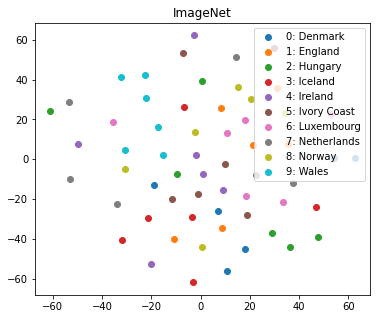

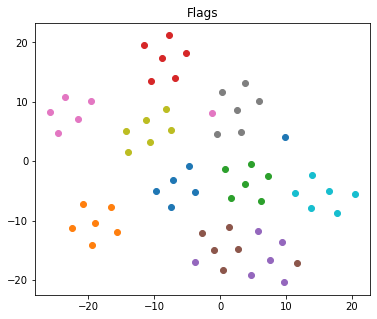

In [ ]:
############################################################
# Fit and transform with a TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=1) 

############################################################
# Project the data in 2D
imageNet_X_2d = tsne.fit_transform(imageNet_feats)
flag_X_2d = tsne.fit_transform(flag_feats)

############################################################
# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(imageNet_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Denmark
    class0 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='tab:blue')
  if labels[i] == 1:
    # 1 is England
    class1 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='tab:orange')
  if labels[i] == 2:
    # 2 is Hungary
    class2 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='tab:green')
  if labels[i] == 3:
    # 3 is Iceland
    class3 =  plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='tab:red')
  if labels[i] == 4:
    # 4 is Ireland
    class4 =  plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='tab:purple')
  if labels[i] == 5:
    # 5 is Ivory Coast
    class5 =  plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='tab:brown')
  if labels[i] == 6:
    # 6 is Luxembourg
    class6 =  plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='tab:pink')
  if labels[i] == 7:
    # 7 is Netherlands
    class7 =  plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='tab:gray')
  if labels[i] == 8:
    # 8 is Norway
    class8 =  plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='tab:olive')
  if labels[i] == 9:
    # 9 is Wales
    class9 =  plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='tab:cyan')
plt.title('ImageNet')
plt.legend((class0, class1, class2, class3, class4,
            class5, class6, class7, class8, class9), 
           ('0: Denmark', '1: England', '2: Hungary','3: Iceland', '4: Ireland',
            '5: Ivory Coast','6: Luxembourg', '7: Netherlands','8: Norway','9: Wales')) 

# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(flag_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Denmark
    class0 = plt.scatter(flag_X_2d[i,0], flag_X_2d[i, 1], c='tab:blue')
  if labels[i] == 1:
    # 1 is England
    class1 = plt.scatter(flag_X_2d[i,0], flag_X_2d[i, 1], c='tab:orange')
  if labels[i] == 2:
    # 2 is Hungary
    class2 = plt.scatter(flag_X_2d[i,0], flag_X_2d[i, 1], c='tab:green')
  if labels[i] == 3:
    # 3 is Iceland
    class3 =  plt.scatter(flag_X_2d[i,0], flag_X_2d[i, 1], c='tab:red')
  if labels[i] == 4:
    # 4 is Ireland
    class4 =  plt.scatter(flag_X_2d[i,0], flag_X_2d[i, 1], c='tab:purple')
  if labels[i] == 5:
    # 5 is Ivory Coast
    class5 =  plt.scatter(flag_X_2d[i,0], flag_X_2d[i, 1], c='tab:brown')
  if labels[i] == 6:
    # 6 is Luxembourg
    class6 =  plt.scatter(flag_X_2d[i,0], flag_X_2d[i, 1], c='tab:pink')
  if labels[i] == 7:
    # 7 is Netherlands
    class7 =  plt.scatter(flag_X_2d[i,0], flag_X_2d[i, 1], c='tab:gray')
  if labels[i] == 8:
    # 8 is Norway
    class8 =  plt.scatter(flag_X_2d[i,0], flag_X_2d[i, 1], c='tab:olive')
  if labels[i] == 9:
    # 9 is Wales
    class9 =  plt.scatter(flag_X_2d[i,0], flag_X_2d[i, 1], c='tab:cyan')


plt.title('Flags')
plt.legend((class0, class1, class2, class3, class4,
            class5, class6, class7, class8, class9), 
           ('0: Denmark', '1: England', '2: Hungary','3: Iceland', '4: Ireland',
            '5: Ivory Coast','6: Luxembourg', '7: Netherlands','8: Norway','9: Wales')) 
plt.show()